In [1]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import xtcav.Utils
from xtcav import Constants
import scipy.interpolate
import math
import time
from sklearn.cluster import AgglomerativeClustering
from sklearn import metrics
import cv2
from scipy.io import loadmat
plt.style.use('seaborn-notebook')

In [3]:
old_imgs = np.load("images_old_531.npy")
new_imgs = np.load("images_new_531.npy")

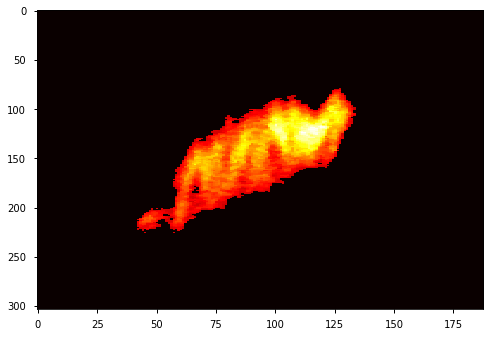

In [4]:
ex = 60
plt.imshow(old_imgs[ex], cmap='hot', interpolation='nearest', aspect='auto')

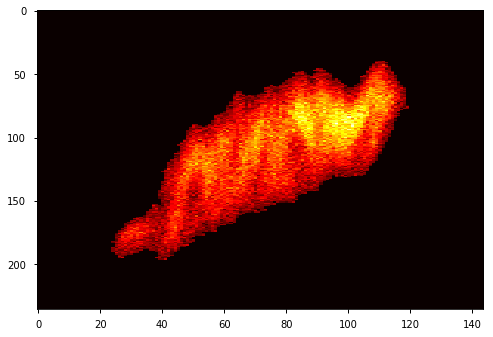

In [5]:
plt.imshow(new_imgs[ex], cmap='hot', interpolation='nearest', aspect='auto')

In [6]:
old_power = np.load("power_old_531.npy")
new_power = np.load("power_new_531.npy")

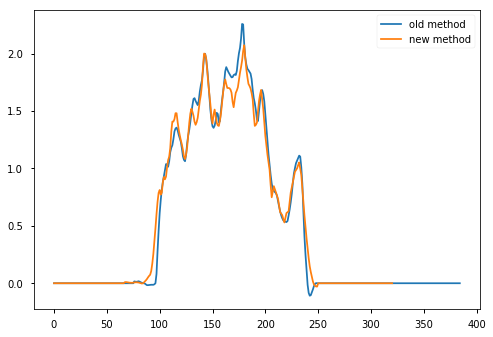

In [7]:
a, = plt.plot(old_power[ex][0][53:], label="old method")
b, = plt.plot(new_power[ex][0], label='new method')
l = plt.legend(handles=[a,b])

## Clustering

In [2]:
def plotProfiles(profiles, groups):
    n_clusters = len(np.unique(groups))
    plt.figure()
    plt.axes([0, 0, 1, 1])
    for l, c in zip(np.arange(n_clusters), 'rgbky'):
        plt.plot(profiles[groups == l].T , c=c, alpha=.3)
    plt.axis('tight')
    plt.axis('off')
    plt.figure()
    plt.axes([0, 0, 1, 1])
    for l, c in zip(np.arange(n_clusters), 'rgbky'):
        plt.plot(np.mean(profiles[groups == l].T , axis=1), c=c, alpha=.3)
        #plt.plot(np.mean(profilesT[model.labels_ == l].T , axis=1) + np.std(profilesT[model.labels_ == l].T , axis=1), c=c, alpha=.3)
        #plt.plot(np.mean(profilesT[model.labels_ == l].T , axis=1) - np.std(profilesT[model.labels_ == l].T , axis=1), c=c, alpha=.3)
    plt.axis('tight')
    plt.axis('off')

In [10]:
def findOptGroups(X, B, max_num):
    num_profiles, t = X.shape
    rand_cluster_variance = {}
    true_cluster_variance = {}
    sd = {}
    #svd of profiles matrix
    column_mean = np.mean(X, axis=0)
    centered = X - column_mean
    u,d,vt = np.linalg.svd(centered)
    x_ = np.matmul(centered, vt.T)
    bounding_box = getBoundingBox(x_)
    
    gap_statistic = {}
    sd = {}
    
    reference_sets = []
    for i in range(B):
        rand_sample = generateRandSample(bounding_box, num_profiles)
        rand_sample = np.matmul(rand_sample, vt) + column_mean
        reference_sets.append(rand_sample)
        
    min_clusters=2
    step = max(int(np.round(float(max_num - min_clusters)/10)),1)
    clusters = list(range(min_clusters+step, max_num+step, step))
    gap_statistic[min_clusters], _ = calcGapStatistic(min_clusters, X, reference_sets)
    
    for clus in clusters:
        gap_statistic[clus], sd[clus] = calcGapStatistic(clus, X, reference_sets)
        if gap_statistic[clus] - sd[clus]*step < gap_statistic[clus-step]:
            return clus-step
    return max_num

def calcGapStatistic(n, X, reference_sets):
    B = len(reference_sets)
    model = AgglomerativeClustering(n_clusters=n, linkage="ward", affinity="euclidean")
    model.fit(X)
    true_cluster_variance = np.log(calcClusterVariance(model.labels_, X, n))
    rand_variance = []
    num_profiles = X.shape[0]
    #generate B random reference datasets
    for k in range(B):        
        model.fit(reference_sets[k])
        rand_variance.append(np.log(calcClusterVariance(model.labels_, reference_sets[k], n)))
    rand_cluster_variance = np.mean(rand_variance)
    sd = np.std(rand_variance)* np.sqrt(1+1./B)
    gap_statistic = rand_cluster_variance - true_cluster_variance
    print gap_statistic, sd
    return gap_statistic, sd

def calcClusterVariance(assignments, data, num_clusters):
    d = 0
    for group in range(num_clusters):
        points = data[assignments == group,:]
        center = np.mean(points, axis = 0)
        d += sum(np.apply_along_axis(lambda x: np.linalg.norm(x - center)**2, 1, points))
    return d

def generateRandSample(bounding_box, num_profiles):
    return np.apply_along_axis(lambda l : np.random.uniform(l[0], l[1], num_profiles), 1, bounding_box).T
def getBoundingBox(X):
    return [(min(X[:,i]), max(X[:,i])) for i in range(X.shape[1])]

### Old Method

In [5]:
#list_image_profiles = np.load("profiles_diamcc574.npy")
list_image_profiles = np.load("test_profiles.npy")

In [6]:
list_image_stats = [profile[0] for profile in list_image_profiles]
list_physical_units = [profile[3] for profile in list_image_profiles]
list_shot_to_shot = [profile[2] for profile in list_image_profiles]

In [7]:
num_profiles = len(list_image_profiles)           #Total number of profiles
# Obtain physical units and calculate time vector   
#We find adequate values for the master time
maxt = np.amax([np.amax(l.xfs) for l in list_physical_units])
mint = np.amin([np.amin(l.xfs) for l in list_physical_units])
mindt = np.amin([np.abs(l.xfsPerPix) for l in list_physical_units])

#Obtain the number of electrons in each shot
num_electrons = np.array([x.dumpecharge/Constants.E_CHARGE for x in list_shot_to_shot])

#To be safe with the master time, we set it to have a step half the minumum step
dt=mindt/2

#And create the master time vector in fs
t=np.arange(mint,maxt+dt,dt)

profilesT = np.zeros((num_profiles,len(t)), dtype=np.float64)  
for i in range(num_profiles): 
    distT=(list_image_stats[i][0].xCOM-list_image_stats[i][0].xCOM)*list_physical_units[i].xfsPerPix
    profilesT[i,:]=scipy.interpolate.interp1d(list_physical_units[i].xfs-distT,list_image_stats[i][0].xProfile, kind='linear',fill_value=0,bounds_error=False,assume_sorted=True)(t)

In [17]:
num_groups = 5
shots_per_group = int(np.floor(num_profiles/num_groups))   #Number of groups to make


# Obtain physical units and calculate time vector   
maxt=0          #Set an initial maximum, minimum and increment value for the master time vector
mint=0
mindt=1000


group = np.zeros(num_profiles, dtype=np.int32)       #array that will indicate which group each profile sill correspond to
group[:]=-1                             #initiated to -1
t1 = time.time()
for g in range(num_groups):                     #For each group
    currRef=np.where(group==-1)[0]  
    currRef=currRef[0]                  #We pick the first member to be the first one that has not been assigned to a group yet

    group[currRef]=g                   #We assign it the current group

    # We calculate the correlation of the first profile to the rest of available profiles
    err = np.zeros(num_profiles, dtype=np.float64);              
    for i in range(currRef, num_profiles): 
        if group[i] == -1:
            err[i] = np.corrcoef(profilesT[currRef,:],profilesT[i,:])[0,1]**2;

    #The 'shots_per_group-1' profiles with the highest correlation will be also assigned to the same group
    order=np.argsort(err)            
    for i in range(0,shots_per_group-1): 
        group[order[-(1+i)]]=g
t1 = time.time()
nolasing_profiles_old = getLasingOffProfilesAverage(profilesT, list(range(num_profiles)))
print "Time for clustering: ", time.time() - t1

Time for clustering:  0.155467033386


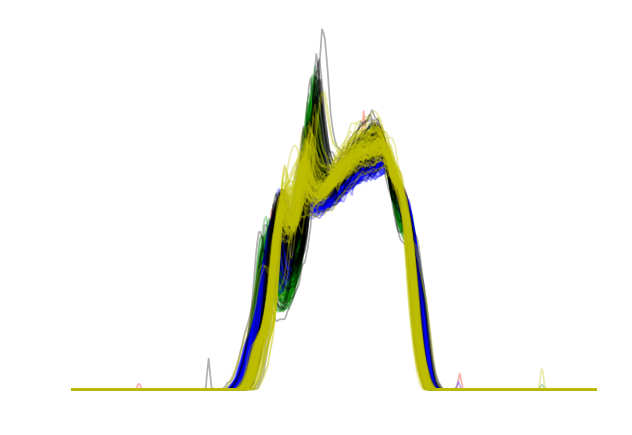

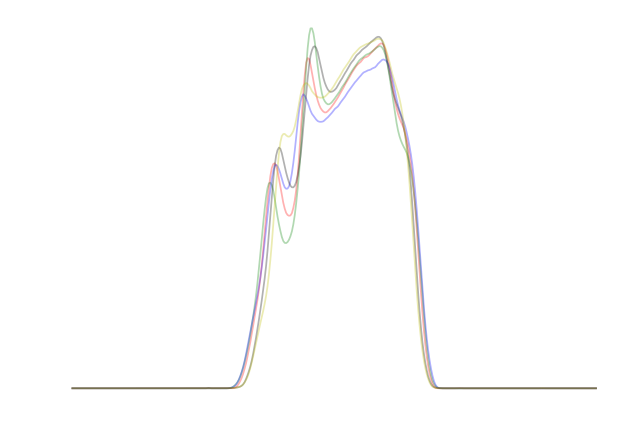

In [18]:
plotProfiles(profilesT, group)

### New clustering methods

In [8]:
def hierarchicalClustering(data, num_clusters=0):
    if not num_clusters:
        num_clusters = findOptGroups(data, 20, 80)
        print num_clusters
    model = AgglomerativeClustering(n_clusters=num_clusters, linkage="ward", affinity="euclidean")
    model.fit(data)
    return model.labels_

0.925490241652 0.017817708264
1.42772317634 0.020333869945
1.56953892557 0.0180611407292
10
4.63729691505


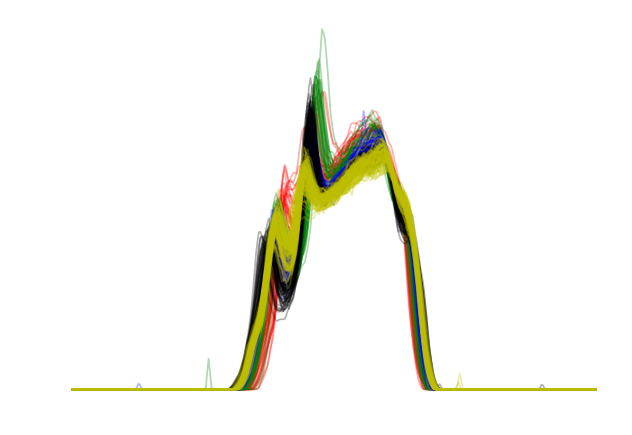

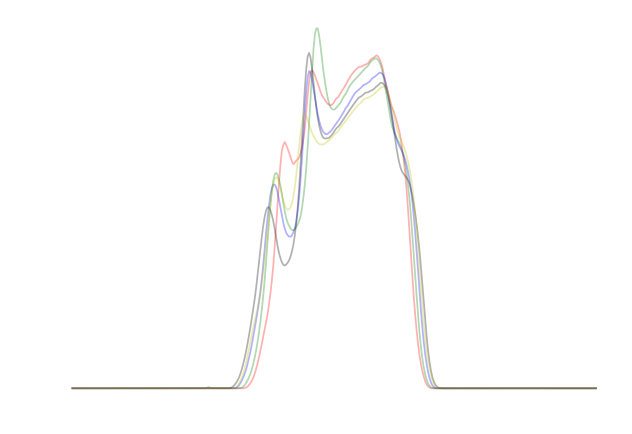

In [11]:
t1 = time.time()
normal_clustering = hierarchicalClustering(profilesT)
print time.time() - t1
plotProfiles(profilesT, normal_clustering)
nolasing_profiles_opt = getLasingOffProfilesAverage(profilesT, normal_clustering)

0.862794685938 0.0219953810126
1.4164674122 0.0168612988838
1.57499450774 0.0164207587821
1.69939922922 0.0154363291787
1.79766852442 0.0149092846913
26
Time for clustering:  1.63147997856


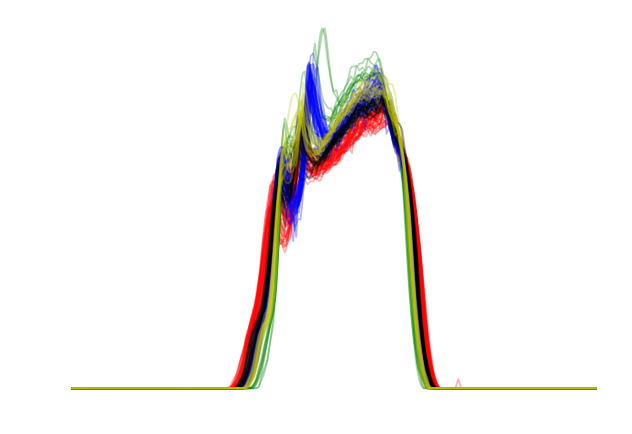

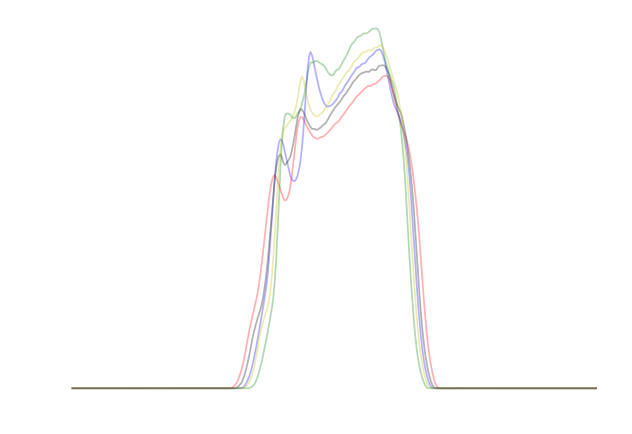

In [33]:
##Using principle components
num_features=30
t2 = time.time()
u, s, v = np.linalg.svd(profilesT.T)
W = u[:, 0:num_features - 1]
newX = np.matmul(profilesT, W)
t1 = time.time()
svd_clustering = hierarchicalClustering(newX)
print "Time for clustering: ", time.time() - t2
plotProfiles(profilesT, svd_clustering)
nolasing_profiles_svd = getLasingOffProfilesAverage(profilesT, svd_clustering)

In [71]:
no_clustering = hierarchicalClustering(profilesT, num_clusters = profilesT.shape[0])
nolasing_profiles_single = getLasingOffProfilesAverage(profilesT, no_clustering, len(np.unique(no_clustering)))

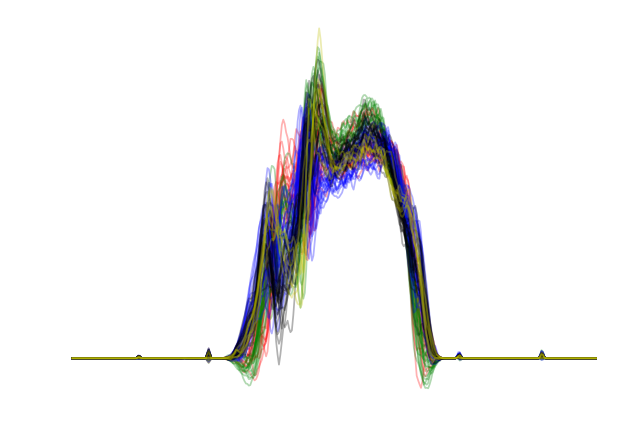

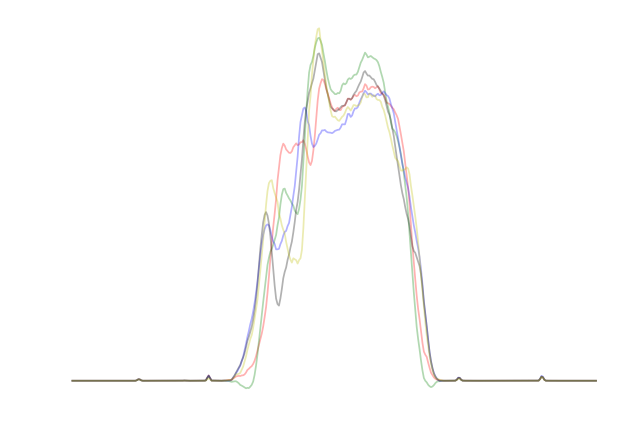

In [51]:
## Example of random sample within
#center profiles and take SVD
column_mean = np.mean(profilesT, axis=0)
centered = profilesT - column_mean
u,d,vt = np.linalg.svd(centered)
x_ = np.matmul(centered, vt.T)
#create random reference data by sampling uniformly from within bounding box
bounding_box = getBoundingBox(x_)
rand_sample = generateRandSample(bounding_box, 100)
rand_sample = np.matmul(rand_sample, vt) + column_mean
rand_clustering = hierarchicalClustering(rand_sample, num_clusters=5)
plotProfiles(rand_sample, rand_clustering)

### Power profiles of lasing on images

In [52]:
lasingon_imgs = np.load("lasingon_ex.npy")
image_profiles = np.load("lasingon_profile_ex.npy")
#image_profiles = np.load("profiles_on_diamcc574.npy")

In [79]:
example_num = 28
example = image_profiles[example_num]
image_profile = xtcav.Utils.ImageProfile(example[0], example[1], example[2], example[3])
processed_image_opt = xtcav.Utils.ProcessLasingSingleShot(image_profile, nolasing_profiles_opt)
power_opt = processed_image_opt.powerECOM[0]
processed_image_old = xtcav.Utils.ProcessLasingSingleShot(image_profile, nolasing_profiles_old)
power_old = processed_image_old.powerECOM[0]
processed_image_svd = xtcav.Utils.ProcessLasingSingleShot(image_profile, nolasing_profiles_svd)
power_svd = processed_image_svd.powerECOM[0]
processed_image_single = xtcav.Utils.ProcessLasingSingleShot(image_profile, nolasing_profiles_single)
power_single = processed_image_single.powerECOM[0]

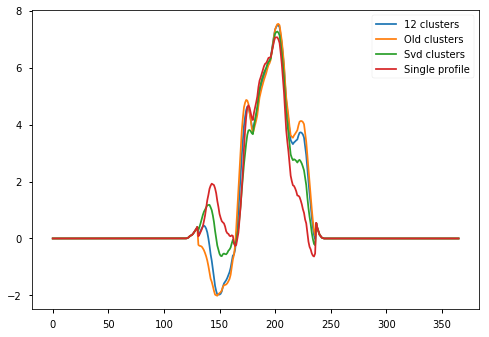

In [80]:
a, = plt.plot(power_opt, label = "12 clusters")
b, = plt.plot(power_old, label = "Old clusters")
c, = plt.plot(power_svd, label = "Svd clusters")
d, = plt.plot(power_single, label = "Single profile")
l = plt.legend(handles=[a,b,c,d])

(-0.5, 681.5)

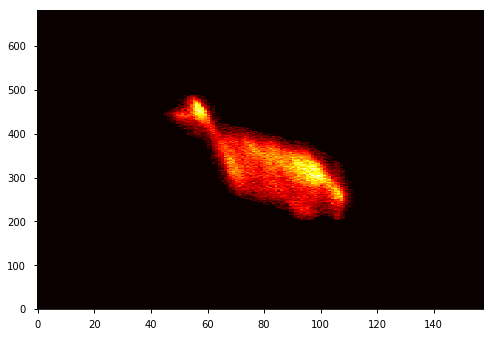

In [71]:
plt.imshow(lasingon_imgs[example_num], cmap='hot', interpolation='nearest', aspect='auto')
plt.ylim(plt.ylim()[::-1])